In [2]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']

In [16]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = True
glob_det = 'stoch'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  

In [ ]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
s_marker = 'd' if glob_det == 'det' else 's'
netid = p_marker+b_marker+s_marker+str(train_bounds)

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

In [17]:
N_mc = 2e6
obs = simulator.sample(1)

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []
res_bin_H0 = [] 
eps_bin_H0 = [] 
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    data_bin_H0.append(mc_samples['x0'])
    res_bin_H0.append(mc_samples['x0']-mc_samples['mu'])
    eps_bin_H0.append(mc_samples['epsilon'])
    
data_bin_H0 = np.concatenate(data_bin_H0)
eps_bin_H0 = np.concatenate(eps_bin_H0)
res_bin_H0 = np.concatenate(res_bin_H0)

100%|██████████| 488/488 [00:04<00:00, 107.11it/s]


In [18]:
### Start by ascertaining the data distribution ###
from scipy.stats import norm
def get_quantiles(indata, nsig:int, sigma_key=False):
    data = np.sort(indata)
    sigmas = np.arange(-nsig,nsig+1,1)
    indices = (len(data)*norm.cdf(sigmas)).astype(int)
    if not sigma_key:
        return data[indices]
    else:
        return np.array([data[indices],sigmas])
    
alldata = data_bin_H0.flatten()
allres = res_bin_H0.flatten()
mean = np.mean(allres)
quantiles = get_quantiles(allres, 3)
quantiles_long = get_quantiles(allres,5)

/tmp/ipykernel_2970309/1955285109.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


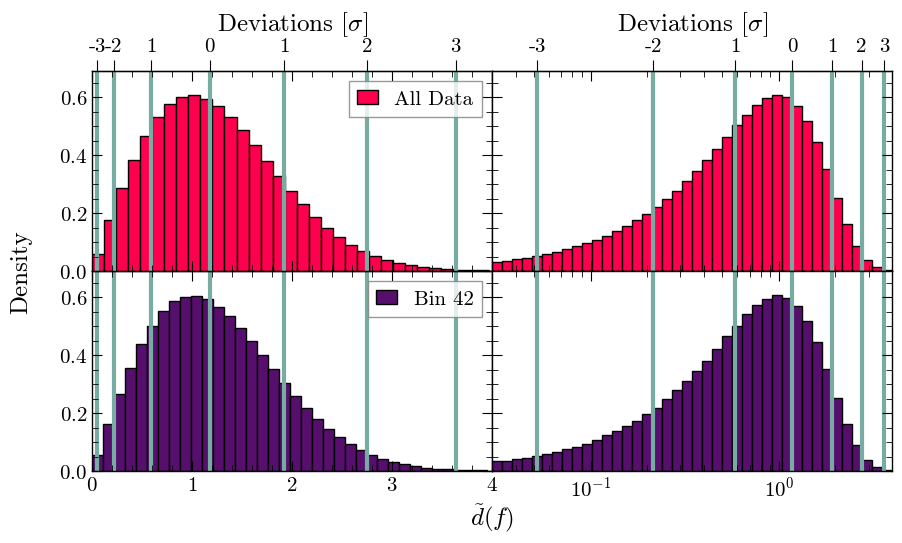

In [19]:
fig, ax1 = pf.create_plot(size=(4,2))
bin = 42
# ax1.set_title(r'$x$ Values Under H$_0,\;$'+f'Bin {bin}')
ax1.hist(res_bin_H0[:,bin], bins=50, density=True, color=mycolors[0],edgecolor='black', label=f'Bin {bin}')

ax1.set_ylabel('Density')
ax1.yaxis.set_label_coords(-0.15,1)
ax1.set_ylim([0,0.69])
ax1.set_xlabel(r'$\tilde{d}(f)$')
ax1.xaxis.set_label_coords(1,-0.15)

ax1.legend()
ax1.set_xlim([0,4])

ax2 = fig.add_axes((0,1,1,1), sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)

ax2.hist(allres, bins=50, density=True, color='#ff004f',edgecolor='black', label=f'All Data')
ax2.set_ylim([0,0.69])
ax2.vlines(quantiles, ymax=100, ymin=-100, color='#77aca2', lw=3)
ax2.legend()

ax3 = fig.add_axes((1,1,1,1), sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.hist(allres, bins=np.logspace(-2,np.log10(4),50), density=True, color='#ff004f',edgecolor='black', label=f'All Data')
ax3.vlines(quantiles, ymax=100, ymin=-100, color='#77aca2', lw=3)
ax3.set_xscale('log')
ax3.set_xlim([0.03,4])

ax4 = fig.add_axes((1,0,1,1), sharex=ax3, sharey=ax1)
plt.setp(ax4.get_yticklabels(), visible=False)
ax4.hist(res_bin_H0[:,bin], bins=np.logspace(-2,np.log10(4),50), density=True, color=mycolors[0],edgecolor='black', label=f'All Data')
ax4.vlines(quantiles, ymax=100, ymin=-100, color='#77aca2', lw=3)
ax4.set_xscale('log')
ax4.set_xlim([0.03,4])

ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(quantiles)
ax2_top.set_xticklabels([-3,-2,1,0,1,2,3])
ax2_top.tick_params(axis='x', which='major', direction='out', length=8)
ax2_top.set_xlabel(r'Deviations [$\sigma$]')
# ax2_top.xaxis.set_label_coords(1,5)


ax3_top = ax3.secondary_xaxis('top')
ax3_top.set_xticks(quantiles)
ax3_top.set_xticklabels([-3,-2,1,0,1,2,3])
ax3_top.tick_params(axis='x', which='major', direction='out', length=8)
ax3_top.tick_params(axis='x', which='minor', direction='out', top=False)
ax3_top.set_xlabel(r'Deviations [$\sigma$]')

ax1.vlines(quantiles, ymax=100, ymin=-100, color='#77aca2', lw=3)

pf.fix_plot([ax1,ax2, ax3, ax4])
plt.tight_layout()
plt.savefig('figs/distribution.png', dpi=700, bbox_inches = 'tight')

/tmp/ipykernel_2970309/2583690072.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


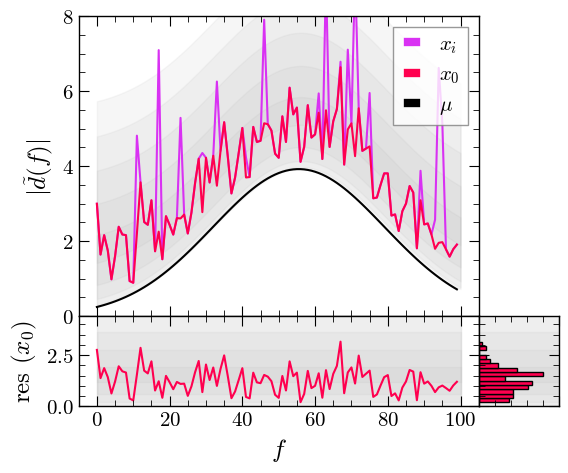

In [ ]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()
plt.savefig(f'figs/data_visu_{s_marker}{b_marker}.png', dpi=700, bbox_inches = 'tight')

In [21]:

from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        
        ###########################################
        if not glob_pve_bounds:
            epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        else:
            epsilon_sim =  (self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype)) * ni
        ###########################################
        
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [22]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    # sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Network_epsilon | 66.5 K | train
--------------------------------------------------
66.5 K    Trainable params
0         Non-trainable params
66.5 K    Total params
0.266     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/opt/ioa/software/anaconda3/envs/python-3.11-2023-12

Training: |          | 0/? [00:00<?, ?it/s]

/opt/ioa/software/anaconda3/envs/python-3.11-2023-12a/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
`Trainer.fit` stopped: `max_epochs=20` reached.


In [24]:
torch.save(network_epsilon, f'networks/network_e_{netid}_complex')
torch.save(model, f'networks/model_e_{netid}_complex')

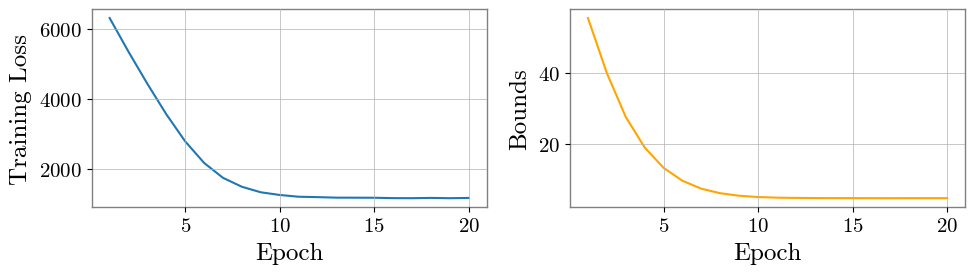

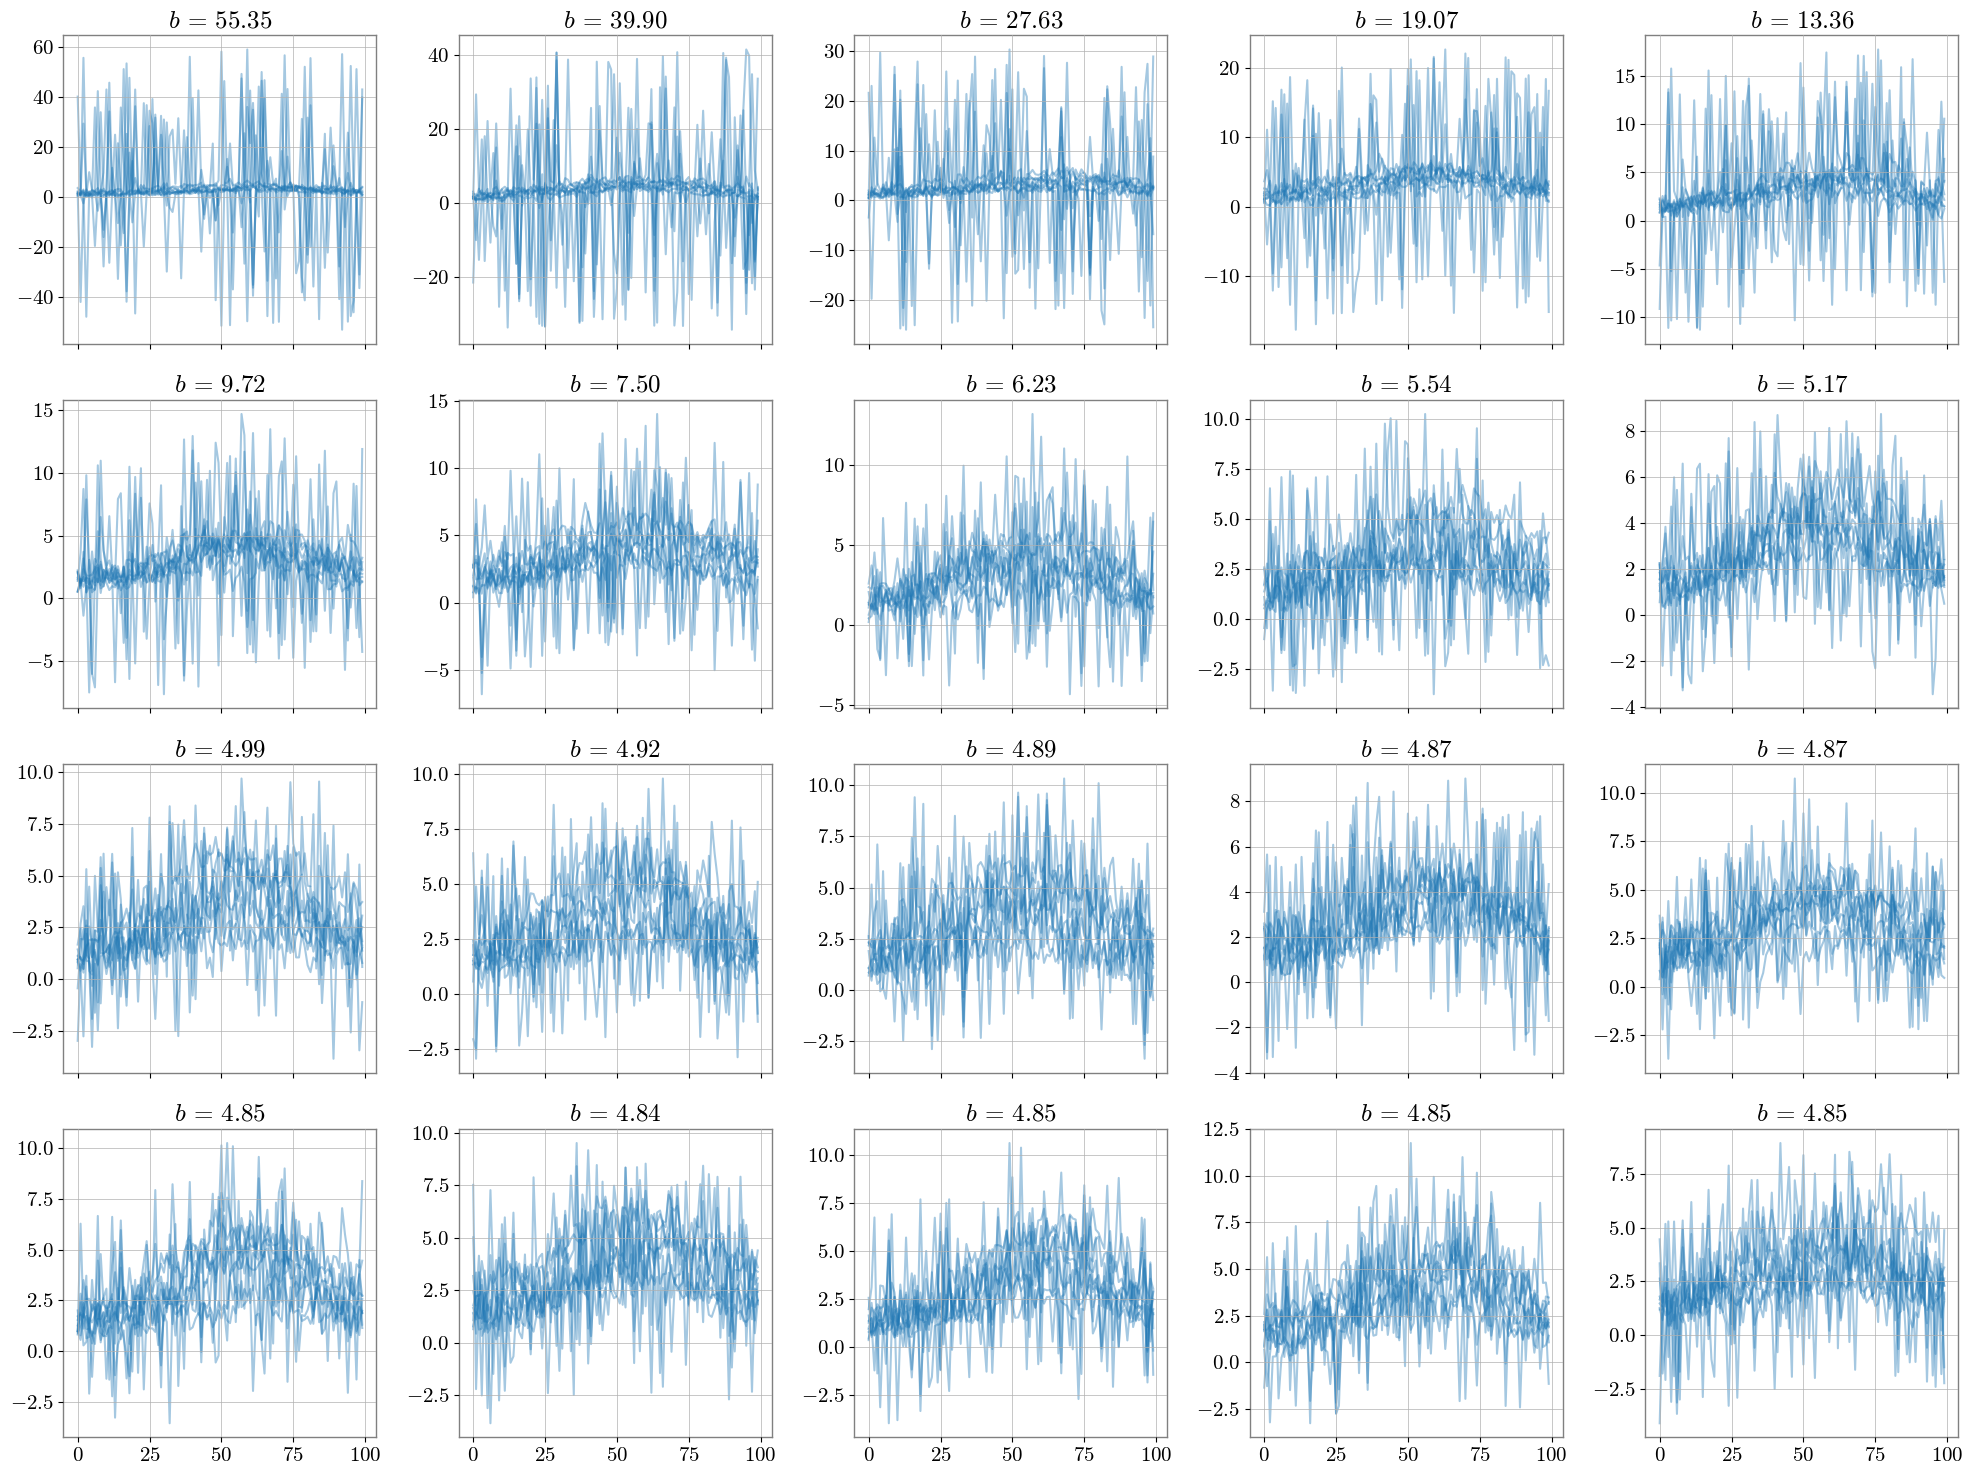

In [ ]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout()
plt.savefig(f'figs/{netid}/bounds.png', dpi=300)
plt.tight_layout();

network_epsilon.bounds()

# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            # axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout()
plt.savefig(f'figs/{netid}/history.png', dpi=300)

In [ ]:
network_epsilon = Network_epsilon()
# checkpoint = torch.load('networks/network_epsilon_complex', weights_only=False,map_location=torch.device('cpu'))
checkpoint = torch.load(f'networks/network_e_{netid}_complex', 
                        weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
network_epsilon.load_state_dict(new_state_dict)
# network_epsilon.cuda().double().eval()
network_epsilon.to(dtype=torch.float32,device='mps').eval()

model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
# checkpoint = torch.load('networks/model_complex', weights_only=False,map_location=torch.device('cpu'))
checkpoint = torch.load(f'networks/model_e_{netid}_complex', 
                        weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
# new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
model.load_state_dict(sd)
# network_epsilon.cuda().double().eval()
model.to(dtype=torch.float32,device='mps').eval()

In [ ]:
bounds = network_epsilon.bounds().detach().cpu().numpy()

In [ ]:
pf.housestyle_rcparams()
n = 50

obs = simulator.sample(1)  
delta_x = obs['xi']

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
# epsilon_nn_obs = network_epsilon.epsilon(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
# variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
# snr_nn_obs = network_epsilon.snr(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
epsilon_obs = get_epsilon(delta_x, ni).squeeze(0)
variance_obs = 1 / get_sigma_epsilon_inv2(ni)
snr_obs = get_snr(delta_x, ni).squeeze(0)

epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)

# For each simultion of the n ones, compute analytical quantities
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig,ax1 = pf.create_plot(size=(3,3))
ax2 = fig.add_axes((1.5,0,1,1))
ax3 = fig.add_axes((2.5,0,0.5,1), sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

axs = [ax1,ax2,ax3]
axs[0].scatter(x=epsilon_obs, y=epsilon_nn_obs, c='#ff004f', s=30, marker='o',linewidths=0.4, alpha=0.7, edgecolor='black')
axs[1].scatter(x=variance_obs, y=variance_nn_obs, c='#ff004f', s=30, marker='o',linewidths=0.4, alpha=0.7, edgecolor='black')
axs[2].hist(variance_nn_obs, orientation='horizontal', bins=20, color='white', edgecolor='black')
    
idx = torch.where(obs['ni']==1)[1]
axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx], c='#77aca2', s=50, marker='x',linewidths=2)
axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx], c='#77aca2', s=50, marker='x',linewidths=2)


axs[0].set_xlabel(r'$\epsilon$ true')
axs[0].set_ylabel(r'$\epsilon$ NN')
axs[1].set_xlabel(r'$\sigma^2$ true')
axs[1].set_ylabel(r'$\sigma^2$ NN')
plt.tight_layout()

pf.fix_plot(axs)

plt.tight_layout()
plt.savefig(f'figs/{netid}/parity.png', dpi=700, bbox_inches = 'tight')

In [ ]:
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)

ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    # ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].to(device='mps', dtype=torch.float32))**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)
ts_bin_H0_epsilon.shape
# np.save('mc_bin/ts_bin_H0_epsilon_pve_complex',ts_bin_H0_epsilon)

# ts_bin_H0_epsilon = np.load('mc_bin/ts_bin_H0_epsilon_pve_complex.npy')

In [ ]:
pf.housestyle_rcparams()
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

fig, axs = plt.subplots(1, 4, figsize=(15, 4), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_epsilon[:, bin]
    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')
axs[0].set_ylabel('Freq Density')

pf.fix_plot(axs)

plt.tight_layout()
plt.savefig(f'figs/{netid}/histogram_complex.png', dpi=300)

In [ ]:
#### NOTE - MIST GOF LIBRARY DOESN'T EXIST - TAKING A GUESS AT HOW THESE FUNCTIONS WORK ####
def t_to_pvalue(ts, df=1):
    return 1 - scipy.stats.chi2.cdf(ts, df)

def t_to_pvalue_empirical(ts_obs, ts0_ref):
    ts0_ref = np.asarray(ts0_ref)
    return (np.sum(ts0_ref >= ts_obs) + 1) / (len(ts0_ref) + 1)


### - NOEMI'S CODE - ###
fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
for i in range(3):
    
    ### - GET SAMPLE - ###
    obs = simulator.sample(1) 
    
    ### - GET NN EPS AND SNR - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    
    ### - ANALYTICAL COMPUTE SNR AND EPS - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2

    ### - COMPUTE P VALUES - ###
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 dof per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid, epsilon_nn, c='C1')
    axs[1, i].plot(grid, epsilon_analytical, c='k', ls='dotted', label='Analytical')
    axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn, c='C1')
    axs[2, i].plot(grid, snr2_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(-0.1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn, c='C1')
    axs[3, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[3, i].set_ylim(1/N_mc/2, 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])

    distortion_locations = grid[ni != 0]
    for plot_row in axs[:, i]:
        for loc in distortion_locations:
                plot_row.axvline(loc, color='black', linestyle='--', lw=0.7, zorder=-1)

    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$\epsilon_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3, 0].set_ylabel("$\mathrm{p}_i$")
for ax in axs:
    pf.fix_plot(ax)
plt.tight_layout();


In [ ]:
DOF = Nbins

# From MCMC samples
ts_sum_H0_epsilon = ts_bin_H0_epsilon.sum(axis=1)
ts_sum_H0_epsilon_mean = ts_sum_H0_epsilon.mean()
ts_sum_H0_epsilon = ts_sum_H0_epsilon - ts_sum_H0_epsilon_mean

# Plot
fig, ax1 = pf.create_plot()

bins = np.linspace(ts_sum_H0_epsilon.min(), ts_sum_H0_epsilon.max(), 100)
ax1.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')
ax1.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='#ff004f', label='Sum $t(x|H_0)$ samples')
ax1.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='black', histtype='step')
ax1.legend(loc='best', fontsize=12, labelspacing=0.1)

plt.tight_layout()
pf.fix_plot([ax1])
plt.savefig(f'figs/{netid}/histogram.png', dpi=700, bbox_inches = 'tight')

In [ ]:
### - INITIALISE SIMULATOR - ###

fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
for i in range(3):
    
    ### - GET A SAMPLE - ###
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=8, 
                                    fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                                    mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
    obs = simulator1.sample(1) 
    
    ### - EVALUATE EPSILON AND SNR^2 FROM NN - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    # epsilon_nn = network_epsilon.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    # snr2_nn = network_epsilon.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   
    
    ### - COMPUTE ANALYTICALLY - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    variance_analytical = 1 / get_sigma_epsilon_inv2(ni_temp)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() - Nbins #((sample['xi'])**2/SIGMA**2).sum()-Nbins
    p_sum_analytical = t_to_pvalue(ts_sum_analytical+Nbins, Nbins)  
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].set_xticklabels(['NN', 'Analytical'])
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    for x, value, color in zip([0, 1], [p_sum_nn, p_sum_analytical], ['C1', 'k']):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value, facecolor=color, edgecolor='black')
    
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    axs[2, i].hist(epsilon_nn/np.sqrt(variance_nn), bins=bins, density=True, color='C1', alpha=0.5, label='NN')
    axs[2, i].hist(epsilon_analytical/np.sqrt(variance_analytical), bins=bins, density=True, color='k', alpha=0.4, label='Analytical')
    axs[2, i].set_xlim(-5*SIGMA, 5*SIGMA)
    axs[2, i].set_xlabel("$\epsilon / \sigma$")
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
axs[2, 0].set_ylabel('Freq Density')
axs[2, 0].legend(loc='best', fontsize=12, labelspacing=0.1)

for ax in axs:
    for a in ax:
        pf.fix_plot([a])
plt.tight_layout();

In [ ]:
N_mc, num_bins = ts_bin_H0_epsilon.shape
ts_bin_flat = ts_bin_H0_epsilon.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    

pv_bin_H0.shape

In [ ]:
selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[j].set_xscale('log')
    axs[j].set_xlabel('p-value')

pf.fix_plot(axs)
plt.tight_layout()
plt.show()

In [ ]:
pf.housestyle_rcparams()
bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1, color=folly)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

pf.fix_plot(axs)
plt.tight_layout()
plt.savefig(f'figs/{netid}/correlations.png', dpi=700, bbox_inches = 'tight')

In [ ]:
Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_epsilon = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

fig, ax1 = pf.create_plot(size=(4,3))
ax1.hist(min_pv_bin_H0_epsilon, bins=50, alpha=0.7, color='skyblue', density=True)
ax1.set_xlabel('Minimum p-value across tests')
ax1.set_ylabel('Density')
ax1.set_title('Histogram of Minimum p-values')
pf.fix_plot([ax1])

In [ ]:
pf.housestyle_rcparams()
### - CENTER AND RANK TS_SUM UNDER H0 - ###
# Center the test statistic (e.g., chi-squared-like) under H0 by subtracting the mean
means = ts_sum_H0_epsilon.mean(axis=0)  # Mean of summed test statistic across MC samples
ts_centered = ts_sum_H0_epsilon - means  # Centered statistic

# Sort and rank the centered values to compute empirical p-values
sorted_ts = np.sort(ts_centered, axis=0)
ranks = np.argsort(np.argsort(-ts_centered, axis=0))  # Descending ranks
p_values = (ranks + 1) / N_mc  # Empirical p-values

pv_sum_H0 = p_values  # Final p-values for the sum test
pv_sum_H0.shape  # Check shape, should be (N_mc,)

### - PLOT HISTOGRAM OF EMPIRICAL P-VALUES - ###
fig,ax1=pf.create_plot(size=(3,3))
ax1.hist(pv_sum_H0, bins=50, alpha=0.7, color=folly)
ax1.set_xlabel('Empirical p-value')
ax1.set_ylabel('Frequency')
ax1.set_title("P-value Distribution\n"+r"(Sum Statistic under $H_0$)")

# This shows the distribution of the p-values under H0 for the sum test

############### THIS COULD BE A MISTAKE REPEAT PLOT ######################
### - PLOT MINIMUM P-VALUES FROM SUM TEST - ###
min_pv_sum_H0_epsilon = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)

ax2 = fig.add_axes((1.3,0,1,1))
ax2.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color=folly)
ax2.set_xlabel('Minimum empirical\np-value (sum tests)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of\nMinimum P-values\n'+r'(Sum Test, under $H_0$)')
#########################################################################

### - COMBINE BIN-WISE AND SUM P-VALUES - ###
Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([
    pv_bin_H0.reshape(Nmc, -1),     # Bin-wise p-values
    pv_sum_H0.reshape(Nmc, -1)      # Sum p-values
], axis=1)  # Combined shape: [N_mc, N_bins + 1]

print(pv_all_H0.shape)  # Sanity check

### - PLOT MINIMUM P-VALUES ACROSS ALL TESTS - ###
min_pv_all_H0_epsilon = np.min(pv_all_H0, axis=1)  # Take minimum p-value across all bins + sum

ax3 = fig.add_axes((2.6,0,1,1))
ax3.hist(min_pv_all_H0_epsilon, bins=50, alpha=0.7, color=folly)
ax3.set_xlabel('Minimum empirical\np-value (all tests)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of\nMinimum P-values\n'+'(All Tests under $H_0$)')

pf.fix_plot([ax1,ax2,ax3])
pf.fix_plot([ax1])
plt.savefig(f'figs/{netid}/pvaluedists.png', dpi=700, bbox_inches = 'tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from cycler import cycler
pf.housestyle_rcparams()

mygold = (218/255, 165/255, 64/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [ ]:
def analyse_obs_epsilon(obs):
    
    target = obs['xi']
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    # epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]

    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    # variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]

    snr2_nn = network_epsilon.snr(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    # snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   

    
    # Compute analytical epsilon and SNR^2 test statistic
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = (obs['xi'] - fit).to(dtype=torch.float32)
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() #((obs['xi'])**2/SIGMA**2).sum()
    p_sum_analytical = t_to_pvalue(ts_sum_analytical, DOF)

    # Compute localized p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_epsilon <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_epsilon <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    c = ["C0", "C1", "C2"]
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color = mycolors[1], ls= (0, (1, 1)), label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")
    # ax1.set_xlabel("$i$", labelpad=1.5)


    # Second column: ax2 and ax3 in the first column c = mycolor[1]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)
    # ax2.set_xlabel("$i$", labelpad=1.5)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, epsilon_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax3.plot(grid, epsilon_analytical, c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    # ax3.set_xlabel("$i$", labelpad=1.5)
    ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])
    ax3.set_title("Residual analysis")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor = mycolors[1], edgecolor = mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    ax6.hist(epsilon_nn / np.sqrt(variance_nn), bins=bins, density=True, color = mycolors[1], alpha=0.5)
    ax6.hist(epsilon_analytical, bins=bins, density=True, histtype='step', color='k', linestyle = 'dotted')
    ax6.set_xlim(-5*SIGMA, 5*SIGMA)
    ax6.set_xlabel("$\epsilon_\mathrm{obs}/\sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    axes = [ax1,ax2,ax3,ax4,ax6]
    pf.fix_plot(axes)

    plt.tight_layout();

In [ ]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=5, 
                                fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                                mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

In [ ]:
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)


In [ ]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=5, 
                                fraction=0, bkg=glob_bkg, dtype=torch.float32, 
                                mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

In [ ]:
fig, ax1 = pf.create_plot()
min_values = np.min(data_bin_H0, axis=1)
ax1.hist(min_values, bins=500)
# ax1.set_xscale('log')
ax1.set_xlim(0,0.05)
ax1.set_title(r'Minimum $x$ Values Under H$_0$')


ax2 = fig.add_axes((0,-1.3,1,1))
ax2.set_title(r'$x$ Values Under H$_0$')

ax2.hist(data_bin_H0[:,0], bins=50)

pf.fix_plot([ax1,ax2])


## NEW PLOTTING STUFF

In [ ]:
def plot_sigma_background(ax, quantile_values):
    """
    Plots a colored background on a matplotlib axis to represent 1, 2, and
    3-sigma confidence intervals.

    The bands are drawn behind other plot elements.

    Args:
        ax (matplotlib.axes.Axes): The axis object to draw on.
        quantile_values (list or np.ndarray): A sorted array of 7 floats
            representing the data values at the quantiles:
            [-3sig, -2sig, -1sig, mean, +1sig, +2sig, +3sig].
    """
    if len(quantile_values) != 7:
        raise ValueError("quantile_values must be an array of 7 elements.")

    # Define nice, semi-transparent colors for the bands
    colors = {
        "1_sigma": "#50f19e",  # Pastel Blue
        "2_sigma": "#ffa568",  # Pastel Orange
        "3_sigma": "#f82c69",  # Pastel Red
    }

    # Unpack quantile values for clarity
    q_neg3, q_neg2, q_neg1, _, q_pos1, q_pos2, q_pos3 = quantile_values

    # Plot 3-sigma bands (from -3 to -2 and +2 to +3)
    # These are drawn first to be in the back
    ax.axhspan(q_neg3, q_neg2, alpha=0.6, color=colors["3_sigma"], lw=0, zorder=-3)
    ax.axhspan(q_pos2, q_pos3, alpha=0.6, color=colors["3_sigma"], lw=0, zorder=-3)

    # Plot 2-sigma bands (from -2 to -1 and +1 to +2)
    ax.axhspan(q_neg2, q_neg1, alpha=0.6, color=colors["2_sigma"], lw=0, zorder=-2)
    ax.axhspan(q_pos1, q_pos2, alpha=0.6, color=colors["2_sigma"], lw=0, zorder=-2)

    # Plot 1-sigma band (from -1 to +1)
    # This is drawn last to be visually on top of the other bands
    ax.axhspan(q_neg1, q_pos1, alpha=0.6, color=colors["1_sigma"], lw=0, zorder=-1, label='1-3 $\sigma$ intervals')
    
    return True

In [ ]:
fig, ax1 = pf.create_plot(size=(6,1.5))
ax2 = fig.add_axes((0,-1,1,1),sharex=ax1)
ax3 = fig.add_axes((0,-2,1,1),sharex=ax1)
ax4 = fig.add_axes((0,-3,1,1),sharex=ax1)
ax5 = fig.add_axes((1,0,1/6,1), sharey=ax1)
axs = [ax1,ax2,ax3,ax4,ax5]

obs = simulator.sample(1) 

### - GET NN EPS AND SNR - ###
epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2

### - ANALYTICAL COMPUTE SNR AND EPS - ###
ni_temp = torch.eye(Nbins, dtype=torch.float32)
fit = best_fit(obs['xi'][0], simulator)
delta_x = obs['xi'] - fit
epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2

### - COMPUTE P VALUES - ###
_p_nn, _p_analytical = [], []
for idx, ts_bin in enumerate(snr2_nn):
    ts_bin_i = ts_bin_H0_epsilon[:, idx]
    m = ts_bin_i.mean()
    ts0_ref = ts_bin_i - m
    ts_obs = (ts_bin-m)
    _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 dof per bin
p_nn = np.array(_p_nn) 
p_analytical = np.array(_p_analytical)   

### - PLOT - ###
x = obs['xi'][0]
qt_x = get_quantiles(x, nsig=3)
ni = obs['ni'][0] 
epsilon = obs['epsilon'][0] 
grid = torch.linspace(0, 10, len(x))
folly = '#ff004f'

axs[0].plot(grid, obs['xi'][0], c='black')
axs[0].scatter(grid[ni!=0], y=x[ni!=0], c='black', s=30, marker='x',linewidths=1)
axs[0].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
axs[0].set_ylim(0, 6.5)
axs[0].set_xlim(-.5, 10.5)
plt.setp(axs[0].get_xticklabels(), visible=False)
plot_sigma_background(axs[0],quantiles)
axs[0].fill_between([-100,100], quantiles_long[-3], quantiles_long[-2], zorder=-10, color="#e24a82")
axs[0].fill_between([-100,100], quantiles_long[-2], 100, zorder=-10, color="#f01e6b")

axs[4].hist(x, bins=20, density=True, orientation='horizontal', color='white', edgecolor='black')
axs[4].set_xlim(0,0.65)
plt.setp(axs[4].get_yticklabels(), visible=False)
plt.setp(axs[4].get_xticklabels(), visible=False)
plot_sigma_background(axs[4],quantiles)
axs[4].fill_between([-100,100], quantiles_long[-3], quantiles_long[-2], zorder=-10, color="#e24a82")
axs[4].fill_between([-100,100], quantiles_long[-2], 100, zorder=-10, color="#f01e6b")


axs[1].plot(grid, epsilon_nn, c=folly)
axs[1].plot(grid, epsilon_analytical, c='k', ls='dotted', label='Analytical')
axs[1].set_ylim(0, 6.5)
axs[1].axhline(0, color='#b0b0b0', linestyle='--')
plt.setp(axs[1].get_xticklabels(), visible=False)

axs[2].plot(grid, snr2_nn, c=folly)
axs[2].plot(grid, snr2_analytical, c='k', ls='dotted', label='Analytical')
axs[2].set_ylim(-0.1, 25)
plt.setp(axs[2].get_xticklabels(), visible=False)


axs[3].semilogy(grid, p_nn, c=folly)
axs[3].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
axs[3].set_ylim(1/N_mc/2, 1)
axs[3].grid(True, axis='y')

distortion_locations = grid[ni != 0]
for i,plot_row in enumerate(axs[:-1]):
    for loc in distortion_locations:
            if i!=0:
                plot_row.axvline(loc, color="#918989FF",  lw=0.5, zorder=-1)
            else:
                plot_row.axvline(loc, color='#ffffff',  lw=1, zorder=-1)
axs[0].set_ylabel(r'$\tilde{d}(f)$')
axs[1].set_ylabel(r"$\epsilon_i$")
axs[2].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3].set_ylabel("$\mathrm{p}_i$")
pf.fix_plot(axs)

plt.tight_layout()
plt.savefig(f'figs/{netid}/single_epsilon_map2.png', dpi=700, bbox_inches = 'tight')


In [ ]:
simulator2 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=10, 
                                fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                                mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []
eps_bin_H0 = []
network_pvalue = []
for _ in tqdm(range(N_batch)):
    global mc_samples
    mc_samples = simulator2.sample(batch_size)
    data_bin_H0.append(mc_samples['x0'])
    eps_bin_H0.append(mc_samples['epsilon'])
    network_pvalue.append(network_epsilon.snr(mc_samples['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy()**2)
    
data_bin_H0 = np.concatenate(data_bin_H0)
eps_bin_H0 = np.concatenate(eps_bin_H0)
network_pvalue = np.concatenate(network_pvalue)

In [ ]:
fig,ax1 = pf.create_plot(size=(3.5,3))
ax1.scatter(eps_bin_H0[:10000], network_pvalue[:10000],s=.5, alpha=0.1, color=folly)
ax1.set_xlabel(r'$\epsilon$ Analytical')
ax1.set_ylabel(r'$\mathrm{SNR}_i^2$')
ax1.set_xlim([0,8])
ax1.set_ylim([0,40])
pf.fix_plot([ax1])
plt.tight_layout()
plt.savefig(f'figs/{netid}/preditction_distribution.png', dpi=700, bbox_inches = 'tight')

### *NB* Model here trained in separate document to prevent variables crossing over

In [ ]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [ ]:
network_BCE = Network_BCE()
checkpoint = torch.load('networks/network_BCE_pveLong_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
network_BCE.load_state_dict(new_state_dict)
# network_BCE.cuda().double().eval()
network_BCE.to(dtype=torch.float32,device='mps').eval()

model_BCE = BCELossModule(network_BCE, learning_rate=3e-3)
checkpoint = torch.load('networks/model_BCE_pveLong_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
# new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
model_BCE.load_state_dict(sd)
# network_BCE.cuda().double().eval()
model_BCE.to(dtype=torch.float32,device='mps').eval()

In [ ]:
def dict_to_mps(x):
    if isinstance(x, dict):
        return {k: dict_to_mps(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(device='mps')
    elif isinstance(x, list):
        return [dict_to_mps(item) for item in x]
    else:
        return x

def dict_to_cpu(x: dict) -> dict:
    out = {}
    for key, val in x.items():
        if isinstance(val, torch.Tensor):
            out[key] = val.to(device='cpu')
        else:
            out[key] = val
    return out


def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_mps(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

In [ ]:
N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
eps_real_BCE = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
    eps_real_BCE.append(mc_samples['epsilon'])
ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)
eps_real_BCE = np.concatenate(eps_real_BCE)

ts_bin_H0_BCE.shape

In [ ]:
plt.hist(ts_bin_H0_BCE[:,0], density=True, bins=20)

In [ ]:

# Compare with chi2 with df = 1
grid = np.linspace(-1, 6, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=-1)

fig, axs = plt.subplots(1, 4, figsize=(13, 3), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_BCE[:, bin]
    m = ts_bin_i.mean()

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i-m, bins=200, density=True, color=mycolors[0], alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-2, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')

pf.fix_plot(axs)
plt.tight_layout()
plt.savefig(f'figs/{netid}/BCE_tis.png', dpi=700, bbox_inches = 'tight')

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2)[0]-1

    # Compute p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx] + 1, 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid,  ts_bin_obs-ts_bin_obs.min(), c='C1')
    axs[1, i].plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted', label='Analytical')
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])

    axs[2, i].semilogy(grid, p_nn, c='C1')
    axs[2, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(1/N_mc/2, 1)
    axs[2, i].grid(True, axis='y')
    axs[2, i].set_xticks([])
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$t_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel("$\mathrm{p}_i$")

for ax in axs:
    pf.fix_plot(ax)
plt.tight_layout();


In [ ]:
fig, ax1 = pf.create_plot(size=(6,1.5))
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-1,1,1),sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = fig.add_axes((0,-2,1,1),sharex=ax1)
ax4 = fig.add_axes((1,0,1/6,1), sharey=ax1)

axs = [ax1,ax2,ax3,ax4]

obs = simulator.sample(1) 

ts_bin_obs = ts_sbi(obs, model=1)
ts_bin_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2)[0]-1

# Compute p-values
_p_nn, _p_analytical = [], []
for idx, ts_bin in enumerate(ts_bin_obs):
    ts_bin_i = ts_bin_H0_BCE[:, idx]
    m = ts_bin_i.mean()
    ts0_ref = ts_bin_i - m
    ts_obs = (ts_bin-m)
    _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx] + 1, 1)) # 1 Nbins per bin
p_nn = np.array(_p_nn) 
p_analytical = np.array(_p_analytical)   

# Plotting
x = obs['xi'][0]
ni = obs['ni'][0] 
grid = torch.linspace(0, 10, len(x))

axs[0].plot(grid, obs['xi'][0], c='black')
axs[0].scatter(grid[ni!=0], y=x[ni!=0], c='black', s=30, marker='x',linewidths=1)
axs[0].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
axs[0].set_ylim(0, 6.5)
axs[0].set_xlim(-.5, 10.5)
plt.setp(axs[0].get_xticklabels(), visible=False)
plot_sigma_background(axs[0],quantiles)
axs[0].fill_between([-100,100], quantiles_long[-3], quantiles_long[-2], zorder=-10, color="#e24a82")
axs[0].fill_between([-100,100], quantiles_long[-2], 100, zorder=-10, color="#f01e6b")

axs[3].hist(x, bins=20, density=True, orientation='horizontal', color='white', edgecolor='black')
axs[3].set_xlim(0,0.65)
plt.setp(axs[3].get_yticklabels(), visible=False)
plt.setp(axs[3].get_xticklabels(), visible=False)
plot_sigma_background(axs[3],quantiles)
axs[3].fill_between([-100,100], quantiles_long[-3], quantiles_long[-2], zorder=-10, color="#e24a82")
axs[3].fill_between([-100,100], quantiles_long[-2], 100, zorder=-10, color="#f01e6b")

axs[1].plot(grid,  ts_bin_obs-ts_bin_obs.min(), c=folly)
axs[1].plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted', label='Analytical')
axs[1].axhline(0, color='#b0b0b0', linestyle='--')

axs[2].semilogy(grid, p_nn, c=folly)
axs[2].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
axs[2].set_ylim(1/N_mc/2, 1)
axs[2].grid(True, axis='y')

distortion_locations = grid[ni != 0]
for i,plot_row in enumerate(axs[:-1]):
    for loc in distortion_locations:
            if i!=0:
                plot_row.axvline(loc, color="#918989FF",  lw=0.5, zorder=-1)
            else:
                plot_row.axvline(loc, color='#ffffff',  lw=1, zorder=-1)

axs[1].set_ylabel(r"$t_i$")
axs[1].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2].set_ylabel("$\mathrm{p}_i$")
axs[0].set_ylabel(r'$\tilde{d}(f)$')

pf.fix_plot(axs)
plt.tight_layout()
plt.savefig(f'figs/{netid}/BCE_mapping.png', dpi=700, bbox_inches = 'tight')



In [ ]:

DOF = Nbins - 3 # 3 parameters

# From MCMC samples
ts_sum_H0_BCE = ts_bin_H0_BCE.sum(axis=1)
ts_sum_H0_BCE_mean = ts_sum_H0_BCE.mean()
ts_sum_H0_BCE = ts_sum_H0_BCE - ts_sum_H0_BCE_mean

# Plot
fig,ax1=pf.create_plot()

bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
ax1.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')

ax1.hist(ts_sum_H0_BCE, bins=bins, density=True, color=mycolors[0], label='Sum $t(x|H_0)$ samples')
ax1.hist(ts_sum_H0_BCE, bins=bins, density=True, color='black', histtype='step')

ax1.legend(loc='best', fontsize=12, labelspacing=0.1)

pf.fix_plot([ax1])

plt.tight_layout()
plt.savefig(f'figs/{netid}/BCE_hist.png', dpi=700, bbox_inches = 'tight')

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bkg=glob_bkg, 
                                    bounds=5, fraction=0.1, dtype=torch.float32, 
                                    mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
    obs = simulator1.sample(1) 
    
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    p_obs = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE) 
    ts_sum_obs_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2).sum()-DOF
    p_sum_analytical = t_to_pvalue(ts_sum_obs_analytical+DOF, DOF) 
    
    # Plotting
    x = obs['xi'][0]
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(0, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].set_xticklabels(['NN', 'Analytical'])
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    for x, value, color in zip([0, 1], [p_sum_nn, p_sum_analytical], ['C1', 'k']):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value, facecolor=color, edgecolor='black')
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")

for ax in axs:  
    pf.fix_plot(ax)

plt.tight_layout();

In [ ]:
### - START BY CALCULATING BINWISE PVALUES - ### (this cell takes a second)
N_mc, num_bins = ts_bin_H0_BCE.shape
ts_bin_flat = ts_bin_H0_BCE.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    

In [ ]:
pf.housestyle_rcparams()
### -  PLOT SOME INDIVIDUAL BINS - ###
selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')
pf.fix_plot(axs)

plt.tight_layout()
plt.show()

### - NOW PLOT SOME PAIRS OF BINS - ###
bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1, color=mycolors[0])
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)
pf.fix_plot(axs)
    
plt.tight_layout()
plt.savefig(f'figs/{netid}/BCE_correlations.png', dpi=700, bbox_inches = 'tight')
plt.show()


In [ ]:
Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_BCE = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum\np-values (Nmc samples)')
plt.grid(True)
plt.show()


In [ ]:
### - CENTER AND RANK TS_SUM UNDER H0 - ###
# Center the test statistic (e.g., chi-squared-like) under H0 by subtracting the mean
means = ts_sum_H0_BCE.mean(axis=0)  # Mean of summed test statistic across MC samples
ts_centered = ts_sum_H0_BCE - means  # Centered statistic

# Sort and rank the centered values to compute empirical p-values
sorted_ts = np.sort(ts_centered, axis=0)
ranks = np.argsort(np.argsort(-ts_centered, axis=0))  # Descending ranks
p_values = (ranks + 1) / N_mc  # Empirical p-values

pv_sum_H0 = p_values  # Final p-values for the sum test
pv_sum_H0.shape  # Check shape, should be (N_mc,)

### - PLOT HISTOGRAM OF EMPIRICAL P-VALUES - ###
fig,ax1=pf.create_plot(size=(3,3))
ax1.hist(pv_sum_H0, bins=50, alpha=0.7, color=mycolors[0])
ax1.set_xlabel('Empirical p-value')
ax1.set_ylabel('Frequency')
ax1.set_title("P-value Distribution\n"+r"(Sum Statistic under $H_0$)")

# This shows the distribution of the p-values under H0 for the sum test

############### THIS COULD BE A MISTAKE REPEAT PLOT ######################
### - PLOT MINIMUM P-VALUES FROM SUM TEST - ###
min_pv_sum_H0_BCE = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)

ax2 = fig.add_axes((1.3,0,1,1))
ax2.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color=mycolors[0])
ax2.set_xlabel('Minimum empirical\np-value (sum tests)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of\nMinimum P-values\n'+r'(Sum Test, under $H_0$)')
#########################################################################

### - COMBINE BIN-WISE AND SUM P-VALUES - ###
Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([
    pv_bin_H0.reshape(Nmc, -1),     # Bin-wise p-values
    pv_sum_H0.reshape(Nmc, -1)      # Sum p-values
], axis=1)  # Combined shape: [N_mc, N_bins + 1]

print(pv_all_H0.shape)  # Sanity check

### - PLOT MINIMUM P-VALUES ACROSS ALL TESTS - ###
min_pv_all_H0_BCE = np.min(pv_all_H0, axis=1)  # Take minimum p-value across all bins + sum

ax3 = fig.add_axes((2.6,0,1,1))
ax3.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color=mycolors[0])
ax3.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color='black', histtype='step')
ax3.set_xlabel('Minimum empirical\np-value (all tests)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of\nMinimum P-values\n'+'(All Tests under $H_0$)')

pf.fix_plot([ax1,ax2,ax3])
plt.tight_layout()
plt.savefig(f'figs/{netid}_BCE_distributions.png', dpi=700, bbox_inches = 'tight')

In [ ]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

mygold = (218/255, 165/255, 64/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [ ]:
def analyse_obs_BCE(obs):
    
    target = obs['xi']
    
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2)[0]-1
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    ts_sum_obs_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2).sum()-DOF
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx]+1, 1))
    p_nn = np.array(_p_nn)
    p_analytical = np.array(_p_analytical)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)   
    p_sum_analytical = t_to_pvalue(ts_sum_obs_analytical+DOF, DOF)

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_BCE <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_BCE <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color=mycolors[1], label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c=mycolors[1], label=r"$\mathrm{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\mathrm{SBI}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")
    pf.fix_plot([ax1,ax2,ax3,ax4])

    plt.tight_layout();

In [ ]:
# OBS
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bkg=glob_bkg, 
                                bounds=5, fraction=0.2, dtype=torch.float32, 
                                mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 

ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_BCE(obs)
plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn > p_sum_analytical

In [ ]:
def plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    ):
    
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color=mycolors[0], label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(bbox_to_anchor=(0.05, 1), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn_BCE, c=mycolors[1], label=r"$\mathrm{BCE}$")
    ax2.semilogy(grid, p_nn_epsilon, c=mycolors[2], label=r"$\mathrm{SNR}$")
    ax2.semilogy(grid, p_analytical_BCE, c='k', ls='dotted', label=r"Analytical")
    # ax2.semilogy(grid, p_analytical_epsilon, c='blue', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    # ax2.legend(loc='best', fontsize=13, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\mathrm{BCE}$")
    ax3.plot(grid, snr2_nn-snr2_nn.min(), c=mycolors[2], label=r"$\mathrm{SNR}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"Analytical")
    # ax3.plot(grid, snr2_analytical - snr2_analytical.min(), c='blue', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='upper right', fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("Localized $t_i$")
    # ax3.grid(True, axis='y', which='both')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["BCE", "SNR", "Analytical"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_nn_epsilon, facecolor=mycolors[2], edgecolor=mycolors[2])
    ax4.fill_between([1.8, 2.2], 1, p_sum_analytical_epsilon, facecolor='k', alpha=0.5)
    # ax4.fill_between([2., 2.2], 1, p_sum_analytical_BCE, facecolor='blue', alpha=0.5)
    ax4.plot([1.8, 1.8, 2.2, 2.2], [1, p_sum_analytical_epsilon, p_sum_analytical_epsilon, 1], 'k', linestyle='dotted')  
    ax4.set_title("Model validation")
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    
    # SUM
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], alpha=0.5, label='BCE')
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], histtype='step')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], alpha=0.5, label='SNR')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], histtype='step')
    ax6.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', linestyle = 'dotted', label='Analytical')
    ax6.set_xlabel("$t_\mathrm{sum}$ $\mid H_0$")
    ax6.set_title("$\chi^2$")
    # ax6.legend(fontsize=13, loc='best', labelspacing=0.1, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')
    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    mantissa, exp = ('%.2e' % p_glob_all_epsilon).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")
    pf.fix_plot([ax1,ax2,ax3,ax4,ax6])

    plt.tight_layout()

In [ ]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bkg=glob_bkg, 
                                bounds=5, fraction=0.05, dtype=torch.float32, 
                                mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det) 
obs = simulator1.sample(1) 
    
ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    )

plt.savefig(f"figs/{netid}_analytical.pdf", dpi=300, transparent=True)

print(p_sum_analytical_BCE==p_sum_analytical_epsilon, p_sum_nn_BCE>p_sum_analytical_BCE,  p_sum_nn_epsilon>p_sum_analytical_epsilon)

In [ ]:
fig,ax1 = pf.create_plot(size=(3.5,3))
ax1.scatter(eps_real_BCE[:10000], ts_bin_H0_BCE[:10000],s=.8, alpha=0.1, color=mycolors[0])
ax1.set_xlabel(r'$\epsilon$ Analytical')
ax1.set_ylabel(r'$\mathrm{t}_i$')
ax1.set_xlim([0,5])
ax1.set_ylim([0,15])
pf.fix_plot([ax1])
plt.tight_layout()
plt.savefig(f'figs/{netid}_BCE_parity.png', dpi=700, bbox_inches = 'tight')

In [ ]:
import matplotlib.gridspec as gridspec
pf.housestyle_rcparams()

def plot_together_new(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    ):
    
    pf.housestyle_rcparams()
    # fig = plt.figure(figsize=(10, 8), dpi=200)
    # gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    # gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 0], width_ratios=[3, 1], wspace=0.0)
    # ax1 = fig.add_subplot(gs0[0])
    # ax_hist = fig.add_subplot(gs0[1], sharey=ax1)

    spacing = 0.4
    fig, ax1 = pf.create_plot(size=(6,2))
    ax_hist = fig.add_axes((1,0,0.2,1), sharey=ax1)
    plt.setp(ax_hist.get_xticklabels(), visible=False)
    plt.setp(ax_hist.get_yticklabels(), visible=False)

    ax2 = fig.add_axes((0,-1-spacing,1,1),sharex=ax1)
    ax3 = fig.add_axes((0,2*(-1-spacing),1,1),sharex=ax1)

    ax4 = fig.add_axes((1+0.5*spacing,-1-spacing,0.4,1))
    ax6 = fig.add_axes((1+0.5*spacing,2*(-1-spacing),0.4,1))

    ax_text = fig.add_axes((1.1+0.5*spacing,0,0.3,1))
    
    global xi
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label=r"$\mu_{\mathrm{sim}}$")

    for i in range(1,6):
        ax1.fill_between(grid, 0, quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
        ax_hist.fill_between(grid, 0, quantiles_long[-i],  color='#b0b0b0', alpha=0.1)


    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color="#ff7b5a", label=r"$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel(r"$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(bbox_to_anchor=(0.05, 1), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_ylim(0, 6.5)
    ax1.set_title("Data")

    ####### NEW HISTOGRAM #########
    ax_hist.hist(xi, orientation='horizontal', color='white', 
                 edgecolor='black', density=True, bins=np.linspace(0,6,17))
    ax_hist.set_xlim([0,0.7])
    

    # Second column: ax2 and ax3 in the first column
    # ax2 = fig.add_subplot(gs[1, 0])

    # ax2.semilogy(grid, p_nn_BCE, c=mycolors[1], label=r"$\mathrm{BCE}$")
    # ax2.semilogy(grid, p_nn_epsilon, c=mycolors[2], label=r"$\mathrm{SNR}$")

    # --- CHANGE START: Modified plot colors ---
    ax2.semilogy(grid, p_nn_BCE, c=mycolors[0], label=r"$\mathrm{BCE}$")
    ax2.semilogy(grid, p_nn_epsilon, c='#ff004f', label=r"$\mathrm{SNR}$")
    # --- CHANGE END ---
    ax2.semilogy(grid, p_analytical_BCE, c='k', ls='dotted', label=r"Analytical")
    # ax2.semilogy(grid, p_analytical_epsilon, c='blue', ls='dotted', label=r"analytical")
    ax2.set_ylabel(r"$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_title("Anomaly detection")
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    # ax2.legend(loc='best', fontsize=13, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')

    # ax3 = fig.add_subplot(gs[2, 0])
    # --- CHANGE START: Modified plot colors ---
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[0], label=r"$\mathrm{BCE}$")
    ax3.plot(grid, snr2_nn-snr2_nn.min(), c='#ff004f', label=r"$\mathrm{SNR}$")
    # --- CHANGE END ---
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"Analytical")
    # ax3.plot(grid, snr2_analytical - snr2_analytical.min(), c='blue', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='upper right', fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_title(r"Localized $t_i$")
    # ax3.grid(True, axis='y', which='both')
    
    # --- CHANGE START: Add vertical lines for distortion locations ---
    distortion_locations = grid[ni != 0]
    for plot_ax in [ax1, ax2, ax3]:
        for loc in distortion_locations:
            plot_ax.axvline(loc, color='black', lw=1, zorder=-10)
    # --- CHANGE END ---


    # Second column: ax4 and ax6 in the second column

      # Bars
    # ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    
    # --- CHANGE START: Removed analytical bar and adjusted ticks ---
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["BCE", "SNR"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    # --- CHANGE END ---
    
    ax4.set_ylabel(r"$\mathrm{p}_\mathrm{sum}$")
    
    # --- CHANGE START: Modified plot colors ---
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[0], edgecolor='black')
    ax4.fill_between([0.8, 1.2], 1, p_sum_nn_epsilon, facecolor='#ff004f', edgecolor='black')
    # --- CHANGE END ---
    ax4.set_title(r"Model validation")
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    
    # SUM
    # ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
    # --- CHANGE START: Modified plot colors ---
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color=mycolors[0], alpha=0.5, label='BCE')
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color=mycolors[0], histtype='step')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='#ff004f', alpha=0.5, label='SNR')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='#ff004f', histtype='step')
    # --- CHANGE END ---
    ax6.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', linestyle = 'dotted', label='Analytical')
    ax6.set_xlabel(r"$t_\mathrm{sum}$ $\mid H_0$")
    ax6.set_title(r"$\chi^2$")
    # ax6.legend(fontsize=13, loc='best', labelspacing=0.1, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')
    
    # Add on gs[0, 1] text reporting the three global p-values
    # ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    mantissa, exp = ('%.2e' % p_glob_all_epsilon).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")
    pf.fix_plot([ax1,ax2,ax3,ax4,ax6, ax_hist])

    plt.tight_layout()

for i in range(3):
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bkg=glob_bkg, 
                                    bounds=5, fraction=0.05, dtype=torch.float32, 
                                    mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det) 
    obs = simulator1.sample(1) 
        
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
    epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

    plot_together_new(
        obs, 
        ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
        snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
        )

    plt.tight_layout()
    plt.savefig(f'figs/{netid}_complex_comparison_n{i}.png', dpi=700, bbox_inches = 'tight')
    plt.show()

In [ ]:
plt.hist(xi, orientation='horizontal', density=True, bins=13)

In [ ]:
# def plot_together_new(
#     obs,
#     ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
#     snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
#     ):

#     pf.housestyle_rcparams()
#     spacing = 0.4
#     fig, ax1 = pf.create_plot(size=(6,2))
#     ax_hist = fig.add_axes((1,0,0.2,1), sharey=ax1)
#     plt.setp(ax_hist.get_xticklabels(), visible=False)
#     plt.setp(ax_hist.get_yticklabels(), visible=False)

#     ax2 = fig.add_axes((0,-1-spacing,1,1),sharex=ax1)
#     ax3 = fig.add_axes((0,2*(-1-spacing),1,1),sharex=ax1)

#     ax4 = fig.add_axes((1+0.5*spacing,-1-spacing,0.4,1))
#     ax6 = fig.add_axes((1+0.5*spacing,2*(-1-spacing),0.4,1))

#     ax_text = fig.add_axes((1.1+0.5*spacing,0,0.3,1))

#     global xi
#     xi = obs['xi'][0]
#     ni = obs['ni'][0]
#     dist = obs['xi'][0] - obs['x0'][0]
#     grid = torch.linspace(0, Nbins, Nbins)
#     ax1.plot(grid, obs['mu'][0], color='k', label=r"$\mu_{\mathrm{sim}}$")

#     for i in range(1,6):
#         ax1.fill_between(grid, 0, quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
#         ax_hist.fill_between(grid, 0, quantiles_long[-i],  color='#b0b0b0', alpha=0.1)


#     ax1.scatter(grid, xi, c='k', marker='x', s=6)
#     ax1.plot(grid, obs['mu'][0]+dist, color="#ff7b5a", label=r"$\mu_{\mathrm{dist}}$")
#     ax1.set_ylabel(r"$x_\mathrm{obs}$", labelpad=1.5)
#     ax1.legend(bbox_to_anchor=(0.05, 1), fontsize=13, loc='upper left', labelspacing=0.1)
#     ax1.set_ylim(0, 6.5)
#     ax1.set_title("Data")

#     ####### NEW HISTOGRAM #########
#     ax_hist.hist(xi, orientation='horizontal', color='white',
#                  edgecolor='black', density=True, bins=np.linspace(0,6,17))
#     ax_hist.set_xlim([0,0.7])


#     ax2.semilogy(grid, p_nn_BCE, c=mycolors[0], label=r"$\mathrm{BCE}$")
#     ax2.semilogy(grid, p_nn_epsilon, c='#ff004f', label=r"$\mathrm{SNR}$")
#     ax2.semilogy(grid, p_analytical_BCE, c='k', ls='dotted', label=r"Analytical")
#     ax2.set_ylabel(r"$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
#     ax2.set_ylim(1/(N_mc*5), 1)
#     ax2.set_title("Anomaly detection")
#     ax2.yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))
#     ax2.yaxis.set_minor_locator(plt.NullLocator())
#     ax2.grid(True, axis='y', which='major')
#     ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
#     ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])

#     ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[0], label=r"$\mathrm{BCE}$")
#     ax3.plot(grid, snr2_nn-snr2_nn.min(), c='#ff004f', label=r"$\mathrm{SNR}$")
#     ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"Analytical")
#     ax3.set_ylabel(r"$t_\mathrm{obs}$")
#     ax3.legend(loc='upper right', fontsize=13)
#     ax3.set_ylim(-.1, None)
#     ax3.set_title(r"Localized $t_i$")

#     distortion_locations = grid[ni != 0]
#     for plot_ax in [ax1, ax2, ax3]:
#         for loc in distortion_locations:
#             plot_ax.axvline(loc, color='black', lw=1, zorder=-10)

#     ax4.set_yscale('log')
#     ax4.set_ylim(1/(N_mc*5), 1)
#     ax4.set_xticks([0, 1])
#     ax4.set_xticklabels(["BCE", "SNR"])
#     ax4.set_xlim(-0.5, 2 - 0.5)
#     ax4.set_ylabel(r"$\mathrm{p}_\mathrm{sum}$")
#     ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[0], edgecolor='black')
#     ax4.fill_between([0.8, 1.2], 1, p_sum_nn_epsilon, facecolor='#ff004f', edgecolor='black')
#     ax4.set_title(r"Model validation")
#     ax4.yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))
#     ax4.yaxis.set_minor_locator(plt.NullLocator())
#     ax4.grid(True, axis='y', which='major')
#     ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
#     ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])

#     bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
#     ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color=mycolors[0], alpha=0.5, label='BCE')
#     ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color=mycolors[0], histtype='step')
#     ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='#ff004f', alpha=0.5, label='SNR')
#     ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='#ff004f', histtype='step')
#     ax6.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', linestyle = 'dotted', label='Analytical')
#     ax6.set_xlabel(r"$t_\mathrm{sum}$ $\mid H_0$")
#     ax6.set_title(r"$\chi^2$")

#     mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
#     exp = int(exp)
#     textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
#     ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
#                 verticalalignment='center', horizontalalignment='center',
#                 bbox=dict(facecolor=mygold, edgecolor='none'))
#     mantissa, exp = ('%.2e' % p_glob_all_epsilon).split('e')
#     exp = int(exp)
#     textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
#     ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
#                 verticalalignment='center', horizontalalignment='center',
#                 bbox=dict(facecolor=mygold, edgecolor='none'))
#     ax_text.axis('off')
#     ax_text.set_title("Global p-value")
#     pf.fix_plot([ax1,ax2,ax3,ax4,ax6, ax_hist])

#     plt.tight_layout()
#     return fig

# def main():
#     """
#     Generates 20 plots and combines them into a GIF.
#     """
#     num_frames = 20
#     gif_filename = 'animated_comparison.gif'
#     frame_filenames = []
#     temp_dir = 'temp_frames'

#     if not os.path.exists(temp_dir):
#         os.makedirs(temp_dir)

#     for i in range(num_frames):
#         print(f"Generating frame {i+1}/{num_frames}...")
#         # --- Replace with your actual data simulation and analysis ---
#         simulator1 = Simulator_Additive(Nbins=Nbins, sigma=1, bkg=glob_bkg, bounds=5, fraction=0.05, dtype=torch.float32, mode='complex')
#         obs = simulator1.sample(1)

#         ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
#         epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)
#         # ---

#         fig = plot_together_new(
#             obs,
#             ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
#             snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
#         )

#         frame_path = os.path.join(temp_dir, f'frame_{i:02d}.png')
#         fig.savefig(frame_path, dpi=150, bbox_inches='tight')
#         plt.close(fig)  # Close the figure to free up memory
#         frame_filenames.append(frame_path)

#     # Create the GIF
#     print(f"Creating GIF: {gif_filename}")
#     with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
#         for filename in frame_filenames:
#             image = imageio.imread(filename)
#             writer.append_data(image)

#     # Clean up temporary files
#     print("Cleaning up temporary frames...")
#     for filename in frame_filenames:
#         os.remove(filename)
#     os.rmdir(temp_dir)

#     print("Done.")

# main()

In [ ]:
quantiles_long